### General overveiw of avaiable CTD/LADCP, SADCP, and drifter data. Location of ship track, identification of transects, drifter tracks and large-scale features from SLA and SST.

In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import urllib.request
import xarray as xr
import pandas as pd
import glob
import os
#from datetime import datetime
import datetime as dt
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from oceans.datasets import etopo_subset
from oceans.sw_extras import gamma_GP_from_SP_pt
from matplotlib.patches import Polygon
import gsw
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.io
#import pixiedust # for pixie_debugger
import pycwt as wavelet
from pyspec import helmholtz as helm
from pyspec import spectrum as spec    
from itertools import islice # for slice OrderedDict
import holoviews as hv
from holoviews import dim, opts
import geoviews as gv
import geoviews.feature as gf

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
from Benguela.src.met132_ctd_ladcp_functions import load_combine_ladcp_ctd_data #import load_ctd_data
from Benguela.src.met132_scanfish_sadcp_functions import load_combine_sadcp_scanfish_data #import load_ctd_data
import Benguela.src.met132_calc_functions as cf
import Benguela.src.met132_plotting_functions as fg
import Benguela.src.met132_sea_level_functions as sl
import Denmark_Strait.src.spectra_and_wavelet_functions as sw
import Denmark_Strait.src.ssa_core as ssa

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

============================================================================================================================

Load the data

In [2]:
nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
# ====== load bathymetry
filenames = "/Users/North/Documents/temp_offline_backups/mmap/etopo1/etopo1_namibia_coast.nc"
topo = xr.open_dataset(filenames)
# ====== load SST map
filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016323.L3m_DAY_SST_sst_4km.nc"
sst_map_18 = xr.open_dataset(filenames) # lat,lon,sst
filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016324.L3m_DAY_SST_sst_4km.nc"
sst_map_19 = xr.open_dataset(filenames) # lat,lon,sst
filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016327.L3m_DAY_SST_sst_4km.nc"
sst_map_22 = xr.open_dataset(filenames) # lat,lon,sst
filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016328.L3m_DAY_SST_sst_4km.nc"
sst_map_23 = xr.open_dataset(filenames) # lat,lon,sst
# ====== load SSH map
gos_map = xr.open_dataset(nc_dir+'sla_gos.nc')
# ====== load glider track
glider_track = xr.open_dataset(nc_dir+'glider.nc')


In [3]:
# ====== load drifter tracks and velocities
drifters = OrderedDict() # Preallocate output dictionary
for ii in np.arange(1,36+1):
    drifters[('Drifter'+str(ii))] = xr.open_dataset(nc_dir+'drifter_Drifter'+str(ii)+'.nc')
len(drifters)

36

In [4]:
# ====== load SADCP and Scanfish data
scan_sadcp_transects = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects['ScanTransect1'] = xr.open_dataset((nc_dir+'scan_sadcp_transects_1km_ScanTransect1.nc')) 
scan_sadcp_transects['ScanTransect1'] = scan_sadcp_transects['ScanTransect1'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])
scan_sadcp_transects['ScanTransect2'] = xr.open_dataset((nc_dir+'scan_sadcp_transects_1km_ScanTransect2.nc')) 
scan_sadcp_transects['ScanTransect2'] = scan_sadcp_transects['ScanTransect2'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])

sadcp_transects = OrderedDict() # Preallocate output dictionary
sadcp_transects['FullScanTransect1'] = xr.open_dataset((nc_dir+'sadcp_transects_1km_FullScanTransect1.nc')) 
sadcp_transects['FullScanTransect1'] = sadcp_transects['FullScanTransect1'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])

sadcp = xr.open_dataset(nc_dir+'sadcp_1km.nc')

# ====== load CTD and LADCP data
ctd_ladcp_transects = OrderedDict() # Preallocate output dictionary
ctd_ladcp_transects['LADCP_CTD_Transect1'] = xr.open_dataset((nc_dir+'ctd_ladcp_transects_LADCP_CTD_Transect1.nc')) 
ctd_ladcp_transects['LADCP_CTD_Transect1'] = ctd_ladcp_transects['LADCP_CTD_Transect1'].set_index(xy=['x_m','x_km','lat','lon','time','station'])

ladcp = xr.open_dataset(nc_dir+'ladcp.nc').swap_dims({'xy': 'time'})


============================================================================================================================

a1. Movie giving overview of data

In [ ]:
gv.extension('matplotlib')#, 'bokeh')
gv.output(size=300)

# setup SLA contours
# plot sla as background contours; gv.Image for pcolor-like
#gos__select = gos_map.sel(lon=slice(8,16),lat=slice(-30,-22)).load()
#gos__select = gos_map.sel(lon=slice(10,16),lat=slice(-28,-24)).load()
gos__select = gos_map.sel(lon=slice(1.9,16.1),lat=slice(-31.5,-21.5)).load()
gos_dataset = gv.Dataset(gos__select, kdims=['time','lon','lat'], vdims='sla')

# create time vector of image frames
new_dt = (gos__select.time[1]-gos__select.time[0])/4
date_vec = np.arange(gos__select.time[3].values,gos__select.time[-1].values+new_dt.values,new_dt.values)
#date_vec= date_vec[0:100]
shiptail_t = new_dt.values*8
tail_t = new_dt.values*32

# sla image
#sla_map = gos_dataset.to(gv.FilledContours, ['lon','lat']).options(
#    cmap='coolwarm',colorbar=True,clim=(-0.2,0.2),linewidth=0)
sla_map = gv.HoloMap({ttime: gv.FilledContours((gos__select.lon.values,
                                               gos__select.lat.values,
                                               gos__select.sla.sel(time=ttime,method='nearest').values)).options(clabel='Sea level anomaly [m]',
                                                                                                                 cmap='coolwarm',colorbar=True,
                                                                                                                 clim=(-0.5,0.5),linewidth=0)
                   for ttime in date_vec}, kdims='time')

# ship track from sadcp data
ship_track = gv.HoloMap({ttime: hv.Curve((sadcp.lon.sel(time=slice(ttime-shiptail_t,ttime)).values,
                                    sadcp.lat.sel(time=slice(ttime-shiptail_t,ttime)).values))
                   for ttime in date_vec}, kdims='time')
ship_pos = gv.HoloMap({ttime: hv.Scatter((sadcp.lon.sel(time=ttime,method='nearest').values,
                                        sadcp.lat.sel(time=ttime,method='nearest').values))
                       for ttime in date_vec}, kdims='time')

# drifter track; need collate to join together into one Holomap
drifter_list1 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(0,12,1)]).collate()
drifter_list2 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(12,23,1)]).collate()
drifter_list3 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(23,29,1)]).collate()
drifter_list4 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(29,36,1)]).collate()
    
# making better date format
hv.Dimension.type_formatters[np.datetime64] = '%Y-%m-%d'
      
# setup SADCP vector plot
extend_t = np.arange(sadcp.time[0].values,date_vec[-1],(sadcp.time[1].values-sadcp.time[0].values))
sadcp_extend = sadcp.interp(time=extend_t)
depth = sadcp_extend.z.sel(z=-25,method='nearest')
mag = np.sqrt(sadcp_extend.u.sel(z=depth)**2 + sadcp_extend.v.sel(z=depth)**2).fillna(0) # too avoid lots of RuntimeWarnings
angle = (np.pi/2.) - np.arctan2(sadcp_extend.u.sel(z=depth)/mag, sadcp_extend.v.sel(z=depth)/mag)
vskip = 10
vmap = hv.HoloMap({ttime: hv.VectorField((sadcp_extend.lon.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values,
                                          sadcp_extend.lat.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values, 
                                          angle.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values,
                                          mag.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values))
                   for ttime in date_vec}, kdims='time')
## normalize to keep constant across images; need magnitude='Magnitude' otherwise mag is constant
sadcp_vec = vmap.opts(opts.VectorField(magnitude='Magnitude',rescale_lengths=False,pivot='tail',headlength=5,headwidth=3,width=0.015,alpha=0.4))
    
# setup GOS vector plot
mag = np.sqrt(gos__select.ugos**2 + gos__select.vgos**2).fillna(0) # too avoid lots of RuntimeWarnings
angle = (np.pi/2.) - np.arctan2(gos__select.ugos/mag, gos__select.vgos/mag)
vmap2 = gv.HoloMap({ttime: gv.VectorField((gos__select.lon[::2],gos__select.lat[::2],
                                         angle.sel(time=ttime,method='nearest')[::2,::2],mag.sel(time=ttime,method='nearest')[::2,::2]))#.opts(magnitude='Magnitude')
                   for ttime in date_vec}, kdims='time')
# normalize to keep constant across images; need magnitude='Magnitude' otherwise mag is constant
gos_vec = vmap2.opts(opts.VectorField(magnitude=dim('Magnitude').norm()*0.5,rescale_lengths=False))

# combine plots, order matters for overlay
#layout = sadcp_vec.options(color='black',alpha=0.5)
layout = sla_map.options(ylim=(-31,-22),xlim=(2,15.5),fontsize={'title':20, 'labels':20, 'ticks':20})*gos_vec.options(alpha=0.5) \
        *sadcp_vec.options(color='black') \
        *ship_track.options(color='black',alpha=0.5)*ship_pos.options(color='black',s=150) \
        *drifter_list1.opts(opts.Curve(color='k',linewidth=2)) \
        *drifter_list2.opts(opts.Curve(color='k',linewidth=2)) \
        *drifter_list3.opts(opts.Curve(color='k',linewidth=2)) \
        *drifter_list4.opts(opts.Curve(color='k',linewidth=2)) \
        *gf.land.options(scale='10m')*gf.coastline.options(scale='10m') # 50m,110m #39568CFF  yellow=#FDE725FF darketeal = #238A8DFF

#        *drifter_list1.opts(opts.Curve(color='blue',linewidth=2)) \
#        *drifter_list2.opts(opts.Curve(color='#9b2423',linewidth=2)) \
#        *drifter_list3.opts(opts.Curve(color='magenta',linewidth=2)) \
#        *drifter_list4.opts(opts.Curve(color='#238A8DFF',linewidth=2)) \
#        *gf.land.options(scale='10m')*gf.coastline.options(scale='10m') # 50m,110m #39568CFF  yellow=#FDE725FF darketeal = #238A8DFF

#*drifter_list.opts(opts.Curve(color=hv.Palette('Spectral'),linewidth=2)) \

#plot # gv.output(backend='bokeh') # allows for zooming but vectors are all uniform
#hv.output(holomap='mp4',fps=2, dpi=144)
#layout = sla_map.options(ylim=(-28,-24))*gos_vec.options(alpha=0.5)
#layout.opts(aspect=3)
#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie.gif',fps=2)
#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie_all_drifters_colourbyrelease.gif',fps=5, dpi=216)
#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie_all_drifters_colourbyrelease.mp4',fps=5, dpi=216)
#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie_all_drifters_black.gif',fps=5, dpi=216)
#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie_all_drifters_black.mp4',fps=5, dpi=216)
layout

#### Figure caption: The color contours show daily SLA = The sea level anomaly is the sea surface height above mean sea surface. The big arrows show daily absolute geostrophic velocity, derived from SLA. Every second velocity is plotted so it isn’t too crowded. Both are gridded and come from satellite altimetry, from the satellites Jason-3 and Sentinel-3A, Source: https://cds.climate.copernicus.eu. The thin black line shows the ship's track over the past 2 days, with velocities from the ship’s ADCP at a depth of 25 m, and only every 10th value is plotted. The thick color lines are drifter tracks over the past 8 days. The video is updated very 6 hours.


##### Shorter movie

In [ ]:
import holoviews as hv
from holoviews import dim, opts
import geoviews as gv
import geoviews.feature as gf
gv.extension('matplotlib')#, 'bokeh')
gv.output(size=300)

# setup SLA contours
# plot sla as background contours; gv.Image for pcolor-like
#gos__select = gos_map.sel(lon=slice(8,16),lat=slice(-30,-22)).load()
#gos__select = gos_map.sel(lon=slice(10,16),lat=slice(-28,-24)).load()
gos__select = gos_map.sel(lon=slice(8,16.2),lat=slice(-29.5,-23.5)).load()
gos_dataset = gv.Dataset(gos__select, kdims=['time','lon','lat'], vdims='adt')

# create time vector of image frames
new_dt = (gos__select.time[1]-gos__select.time[0])/4
date_vec = np.arange(gos__select.time[3].values,gos__select.time[-1].values+new_dt.values,new_dt.values)
date_vec= date_vec[0:30*4]
shiptail_t = new_dt.values*8
tail_t = new_dt.values*32

# sla image
#sla_map = gos_dataset.to(gv.FilledContours, ['lon','lat']).options(
#    cmap='coolwarm',colorbar=True,clim=(-0.2,0.2),linewidth=0)
sla_map = gv.HoloMap({ttime: gv.FilledContours((gos__select.lon.values,
                                               gos__select.lat.values,
                                               gos__select.adt.sel(time=ttime,method='nearest').values)).options(clabel='Sea level anomaly [m]',
                                                                                                                 cmap='coolwarm',colorbar=True,
                                                                                                                 clim=(-0.5,0.5),linewidth=0)
                   for ttime in date_vec}, kdims='time')

# ship track from sadcp data
ship_track = gv.HoloMap({ttime: hv.Curve((sadcp.lon.sel(time=slice(ttime-shiptail_t,ttime)).values,
                                    sadcp.lat.sel(time=slice(ttime-shiptail_t,ttime)).values))
                   for ttime in date_vec}, kdims='time')
ship_pos = gv.HoloMap({ttime: hv.Scatter((sadcp.lon.sel(time=ttime,method='nearest').values,
                                        sadcp.lat.sel(time=ttime,method='nearest').values))
                       for ttime in date_vec}, kdims='time')

# ctd/ladcp stations
ctd_stations = gv.HoloMap({ttime: hv.Scatter((ladcp.lon.sel(time=slice(ttime-shiptail_t,ttime)).values,
                                    ladcp.lat.sel(time=slice(ttime-shiptail_t,ttime)).values))
                   for ttime in date_vec}, kdims='time')

# drifter track; need collate to join together into one Holomap
#drifter_list = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
#                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
#                       for ttime in date_vec}, kdims='time') for di in range(len(drifters))]).collate()
drifter_list1 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(0,12,1)]).collate()
drifter_list2 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(12,23,1)]).collate()
drifter_list3 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(23,29,1)]).collate()
drifter_list4 = gv.Overlay([gv.HoloMap({ttime: hv.Curve((drifters['Drifter'+str(di+1)].lon.sel(time=slice(ttime-tail_t,ttime)).values,
                                        drifters['Drifter'+str(di+1)].lat.sel(time=slice(ttime-tail_t,ttime)).values)).opts(linewidth=2)
                       for ttime in date_vec}, kdims='time') for di in np.arange(29,36,1)]).collate()

# making better date format
hv.Dimension.type_formatters[np.datetime64] = '%Y-%m-%d'
      
# setup SADCP vector plot
extend_t = np.arange(sadcp.time[0].values,date_vec[-1],(sadcp.time[1].values-sadcp.time[0].values))
sadcp_extend = sadcp.interp(time=extend_t)
depth = sadcp_extend.z.sel(z=-25,method='nearest')
mag = np.sqrt(sadcp_extend.u.sel(z=depth)**2 + sadcp_extend.v.sel(z=depth)**2).fillna(0) # too avoid lots of RuntimeWarnings
angle = (np.pi/2.) - np.arctan2(sadcp_extend.u.sel(z=depth)/mag, sadcp_extend.v.sel(z=depth)/mag)
vskip = 10
vmap = hv.HoloMap({ttime: hv.VectorField((sadcp_extend.lon.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values,
                                          sadcp_extend.lat.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values, 
                                          angle.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values,
                                          mag.sel(time=slice(ttime-shiptail_t,ttime))[::vskip].values))
                   for ttime in date_vec}, kdims='time')
## normalize to keep constant across images; need magnitude='Magnitude' otherwise mag is constant
sadcp_vec = vmap.opts(opts.VectorField(magnitude='Magnitude',rescale_lengths=False,pivot='tail',headlength=5,headwidth=3,width=0.015,alpha=0.4))
    
# setup GOS vector plot
mag = np.sqrt(gos__select.ugos**2 + gos__select.vgos**2).fillna(0) # too avoid lots of RuntimeWarnings
angle = (np.pi/2.) - np.arctan2(gos__select.ugos/mag, gos__select.vgos/mag)
vmap2 = gv.HoloMap({ttime: gv.VectorField((gos__select.lon[::2],gos__select.lat[::2],
                                         angle.sel(time=ttime,method='nearest')[::2,::2],mag.sel(time=ttime,method='nearest')[::2,::2]))#.opts(magnitude='Magnitude')
                   for ttime in date_vec}, kdims='time')
# normalize to keep constant across images; need magnitude='Magnitude' otherwise mag is constant
gos_vec = vmap2.opts(opts.VectorField(magnitude=dim('Magnitude').norm()*0.5,rescale_lengths=False))

# combine plots, order matters for overlay
#layout = sadcp_vec.options(color='black',alpha=0.5)
layout = sla_map.options(ylim=(-29,-24),xlim=(9,16),fontsize={'title':20, 'labels':20, 'ticks':20})*gos_vec.options(alpha=0.5) \
        *sadcp_vec.options(color='black') \
        *ctd_stations.options(alpha=0.5,color='#238A8DFF',s=100,edgecolors='k')  \
        *ship_track.options(color='black',alpha=0.5)*ship_pos.options(color='black',s=150) \
        *drifter_list1.opts(opts.Curve(color='#9b2423',linewidth=2)) \
        *drifter_list2.opts(opts.Curve(color='blue',linewidth=2)) \
        *drifter_list3.opts(opts.Curve(color='magenta',linewidth=2)) \
        *drifter_list4.opts(opts.Curve(color='#238A8DFF',linewidth=2)) \
        *gf.land.options(scale='10m')*gf.coastline.options(scale='10m') # 50m,110m #39568CFF  yellow=#FDE725FF darketeal = #238A8DFF

#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie.gif',fps=2)
#hv.save(layout, '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/MET132_overview_movie_ship_passage_colourbyrelease.mp4',fps=5, dpi=216)
layout

#### Figure caption: The color contours show daily SLA = The sea level anomaly is the sea surface height above mean sea surface. The big arrows show daily absolute geostrophic velocity, derived from SLA. Every second velocity is plotted so it isn’t too crowded. Both are gridded and come from satellite altimetry, from the satellites Jason-3 and Sentinel-3A, Source: https://cds.climate.copernicus.eu. The thin black line shows the ship's track over the past 2 days, with velocities from the ship’s ADCP at a depth of 25 m, and only every 10th value is plotted. The circles show CTD/LADCP stations. The thick color lines are drifter tracks over the past 8 days. The video is updated very 6 hours.


In [ ]:
####

============================================================================================================================

a. Mesoscale: Overview of region, upwelling and filament feature observed during cruise

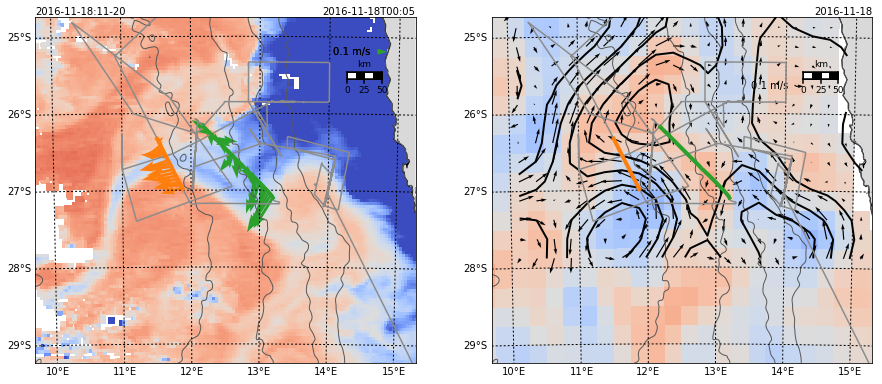

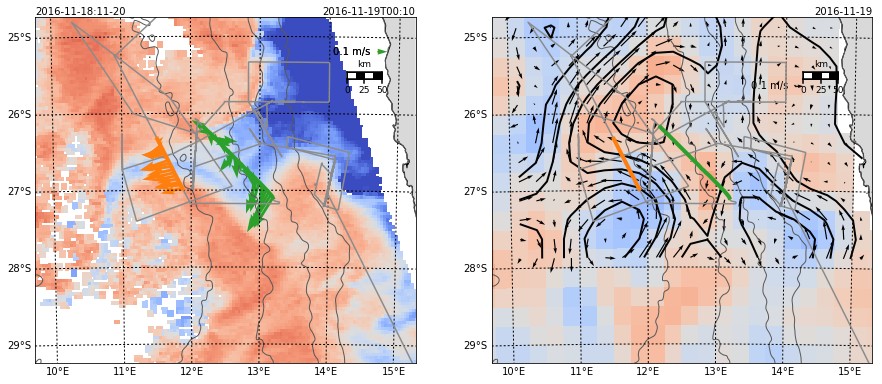

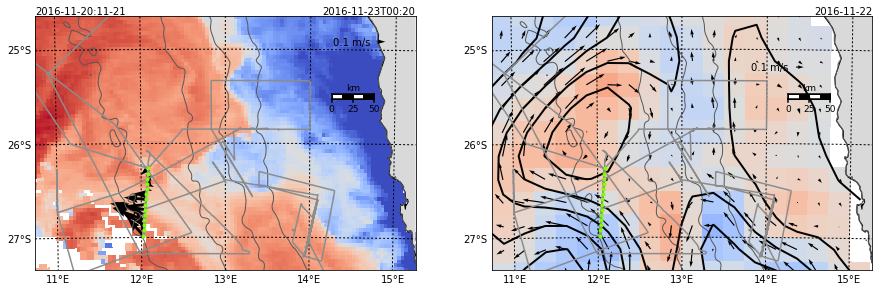

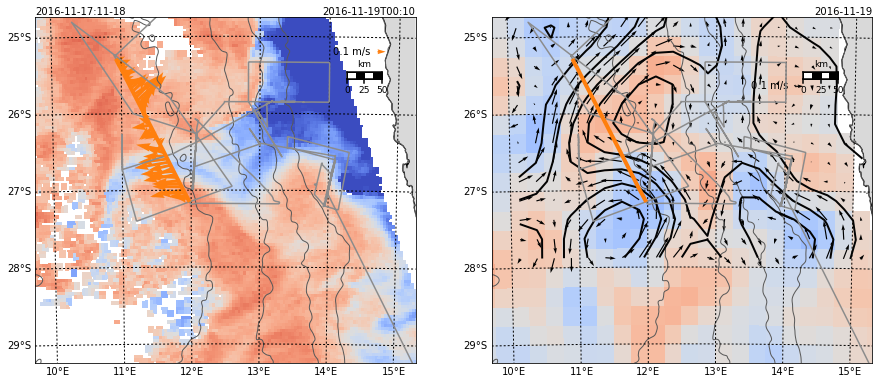

In [4]:
select_transects = OrderedDict(islice(scan_sadcp_transects.items(), 0, 3))
fg.plot_map_view(sadcp=sadcp, scan_sadcp = select_transects,topo=topo,
                 sst_map=sst_map_18,sst_map1=gos_map.sel(time='2016-11-18',lon=slice(10,16),lat=slice(-28,-24)),ssh_name='adt',
                 x_lim=[0,150])
fg.plot_map_view(sadcp=sadcp, scan_sadcp = select_transects,topo=topo,
                 sst_map=sst_map_19,sst_map1=gos_map.sel(time='2016-11-19',lon=slice(10,16),lat=slice(-28,-24)),ssh_name='adt',
                 x_lim=[0,150])
select_transects = OrderedDict(islice(ctd_ladcp_transects.items(), 0, 3))
fg.plot_map_view(sadcp=sadcp, ctd_data = None, ctd_ladcp = select_transects, topo=topo,
                 sst_map=sst_map_23,sst_map1=gos_map.sel(time='2016-11-22',lon=slice(10,16),lat=slice(-28,-24)),ssh_name='adt',
                 x_lim=[0,150])
fg.plot_map_view(sadcp=sadcp, scan_sadcp = sadcp_transects,topo=topo,
                 sst_map=sst_map_19,sst_map1=gos_map.sel(time='2016-11-19',lon=slice(10,16),lat=slice(-28,-24)),ssh_name='adt',
                 x_lim=[0,150])
#fg.plot_map_view(sadcp, ctd, glider_track, ladcp, scanfish, scan_sadcp[trans_ind], ctd_ladcp[trans_ind],
#                              topo,sst_map,gos_map.sel(time='2016-11-18',lon=slice(10,16),lat=slice(-28,-24)),ssh_name='adt',x_lim=[0,150])

#### Figure caption: Plots show ship tracks (grey lines), location of select transects (thick colored lines) and in left panels, velocity vectors near z=40 m along these transects from ship ADCP and lowered ADCP. The background is SST in the left panels, and Rossby number (colour) and SSH (contour lines) in the right panels. Black vectors in the right panels show currents derived from SSH. CTD/LADCP stations are black or green circles. Each row is a different day, corresponding to the time of the highlighted transect. Image dates are in the top right, transect dates the top left.

============================================================================================================================

b. Cross-frontal variability; description of filament fronts from Scanfish transects

/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1176b5550>,
      dtype=object)

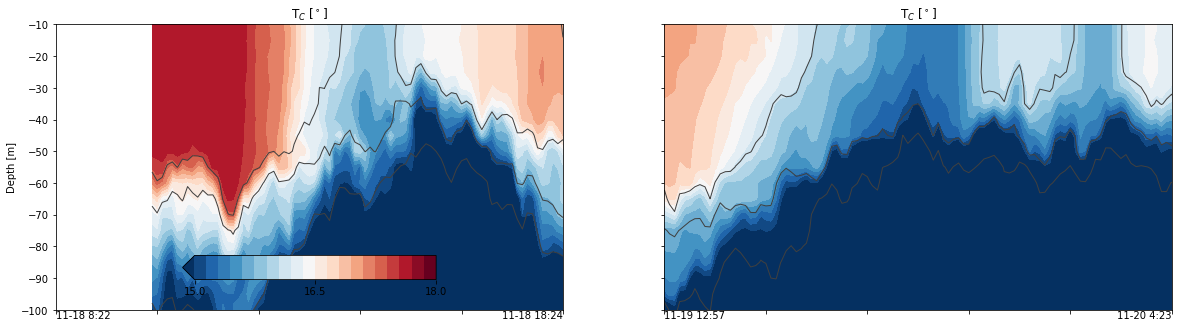

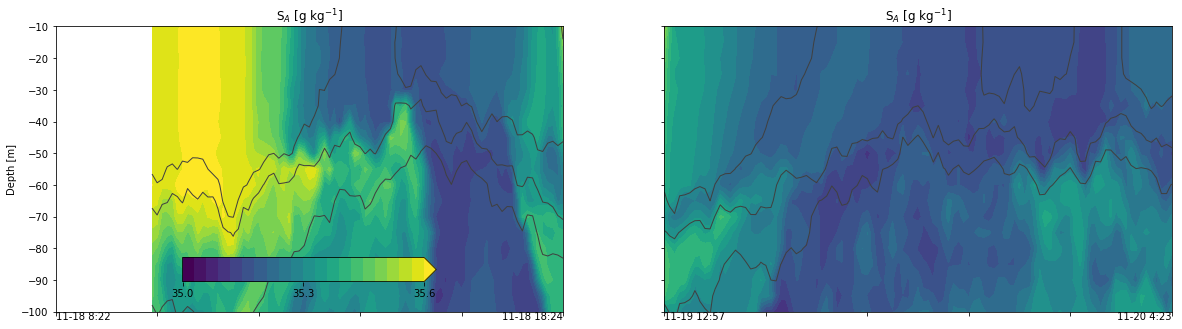

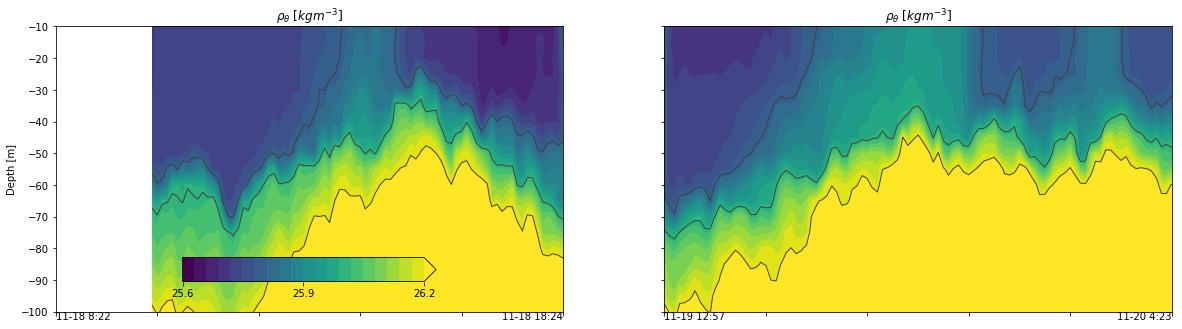

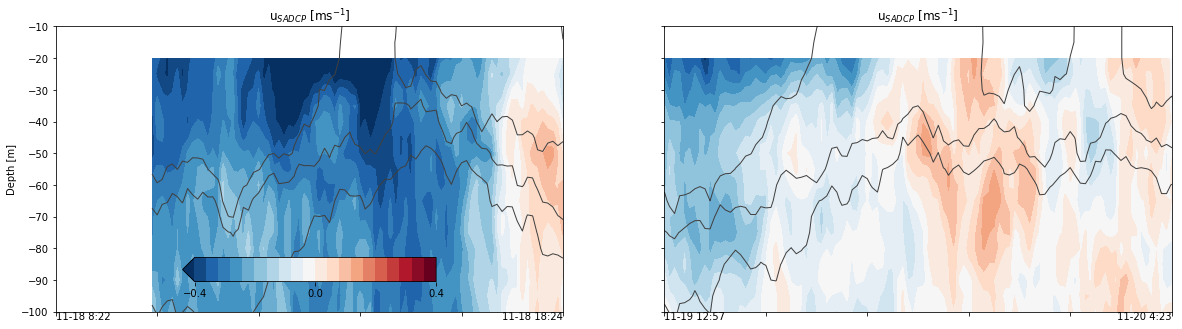

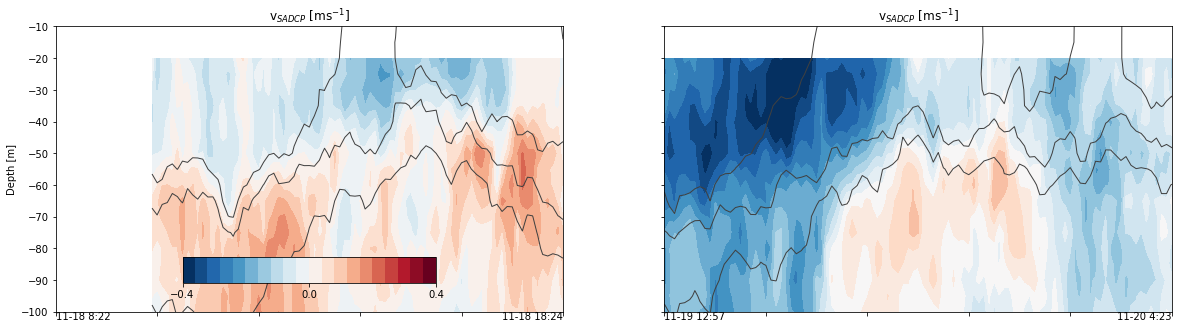

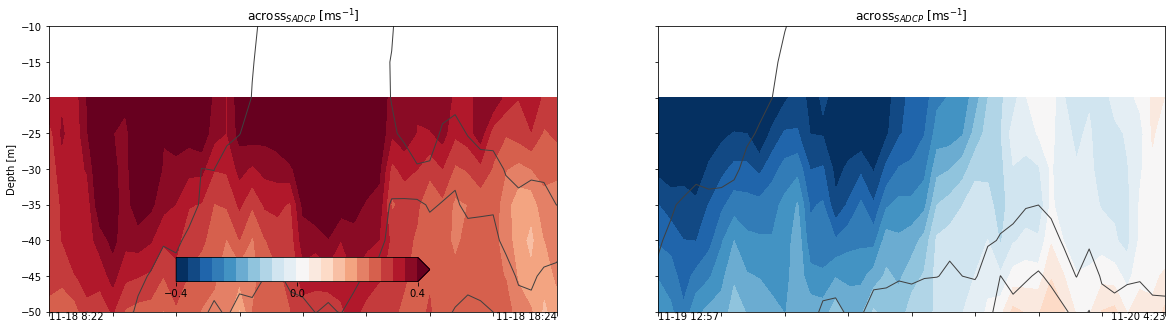

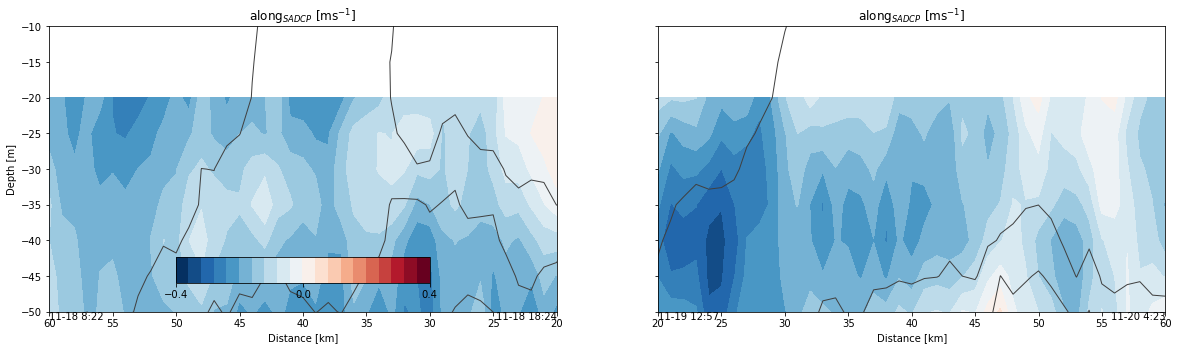

In [4]:
# each call to plot_profile_view makes a row of plots for the variable "var_names"
# The dates in the lower left hand corners indicate the start of the section
# All colorbars are consistent for all instruments
select_transects = OrderedDict(islice(scan_sadcp_transects.items(), 0, 3))
x_lim = [0,100]
y_lim = [-100,-10]
var_names = list(('CT',''))

fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim)
var_names = list(('SA',''))
fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim)
var_names = list(('sigma_0',''))
fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim)
var_names = list(('u',''))
fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim)
var_names = list(('v',''))
fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim)#, last_row_flag=1)
var_names = list(('across',''))
fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim)#, last_row_flag=1)
var_names = list(('along',''))
fg.plot_profile_view(select_transects, None, var_names, x_lim=x_lim, y_lim=y_lim, last_row_flag=1)
## check higher res ADCP data
#var_names = list(('v',''))
## need to change from OrderedDict to list
#fg.plot_profile_view(list((sadcp_transects['ScanTransect1'],sadcp_transects['ScanTransect2'])), None, var_names, x_lim=x_lim, y_lim=y_lim, last_row_flag=1)

# filament not cut off from deeper water; is there upwelling along isopycnals?
# compare geostrophic velocities with measured to get ageostrophic component
# how does currents vary across filament, where are maxima; use LADCP repeate transects to see how this changes in time, effect of storm

#### Figure caption: Profiles along two transect crossing the filament. Left panel: first crossing with a scanfish, right panel second crossing. The plot titles show the variable, where the last three rows are velocity components. In all plots, the black contour lines are density.